In [1]:
# import capytaine as cpy
import autograd.numpy as np
import matplotlib.pyplot as plt
import xarray as xr
# from math import comb

import wecopttool as wot
import os
import Pioneer_Inverted_Pendulum as pip
from scipy.optimize import Bounds

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

wot.set_loglevel('ERROR', capytaine=False)
data_path = os.path.join('pioneer_data')

In [2]:
wavefreq = 0.325
f1_reg = wavefreq
nfreq_reg = 5
amplitude = 0.15

waves_regular = wot.waves.regular_wave(f1_reg, nfreq_reg, wavefreq, amplitude)

In [3]:
NPIP = pip.NonlinearInvertedPendulumPTO(f1 = f1_reg,
                                        nfreq = nfreq_reg,
                                        ndof = 1,
                                        control_type = 'PI')

In [4]:
LinPIP = pip.LinearizedInvertedPendulumPTO(f1 = f1_reg,
                                        nfreq = nfreq_reg,
                                        ndof = 1,
                                        control_type = 'PI')

In [5]:
wec_nl = pip.PioneerBuoy.from_empirical_data(f1_reg, nfreq_reg, 
                                            f_add = NPIP.f_add,
                                            constraints = NPIP.constraints)
wec_lin = pip.PioneerBuoy.from_empirical_data(f1_reg, nfreq_reg, 
                                            f_add = LinPIP.f_add,
                                            constraints = LinPIP.constraints)  

In [6]:
res_lin = LinPIP.solve(wec_lin, waves_regular)
x_wec_0, x_opt_0 = wec_lin.decompose_state(res_lin[0].x)


wave 0, exit mode: 0, nit: 30, cntr: PI, avg. power: -21.08W


In [7]:
x_opt_0[:NPIP.nstate_pto]

array([-15.17196179,   6.273728  ])

### Next steps
#### make function for bounding PID, 
#### make function for scaling of xopt
#### make postprocessing function

In [8]:
res_nl = NPIP.solve(wec_nl, waves_regular, x_wec_0, x_opt_0)


wave 0, exit mode: 0, nit: 17, cntr: PI, avg. power: -28.35W


In [9]:
nsubsteps = 5
wec_fdom, wec_tdom = wec_nl.post_process(wec_nl, res_nl, waves_regular, nsubsteps=nsubsteps)


In [10]:
nsubsteps = 5

wec_fdom, wec_tdom, pen_fdom, pen_tdom = NPIP.post_process(wec_nl, res_nl, waves_regular, nsubsteps=nsubsteps)

In [11]:
wec_pos = wec_tdom[0]['pos'].squeeze()
t = wec_tdom[0].time.values


In [12]:
x_wec, x_opt = wot.decompose_state(res_nl[0].x, 1, nfreq_reg)
x_pen = x_opt[NPIP.nstate_pto:]
pen_pos = np.dot(wec_nl.time_mat_nsubsteps(nsubsteps), x_pen)

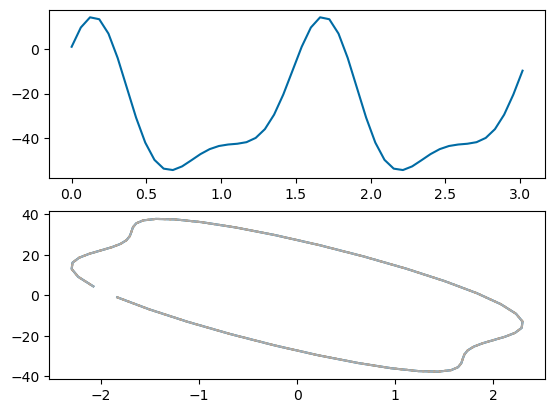

In [15]:
pto_elec_power = NPIP.electrical_power(wec_nl, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_vel = NPIP.rel_velocity(wec_nl, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_torque = NPIP.torque_from_PTO(wec_nl, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)

fig, axes = plt.subplots(2,1)
axes[0].plot(t,pto_elec_power)

axes[1].plot(pto_vel, pto_torque)
axes[1].plot(pto_vel, NPIP.f_add['Generator'](wec_nl, x_wec, x_opt, waves_regular, nsubsteps = nsubsteps), ':')
axes[1].plot(pto_vel, pen_tdom[0]['torque'].sel(type = 'Generator'))

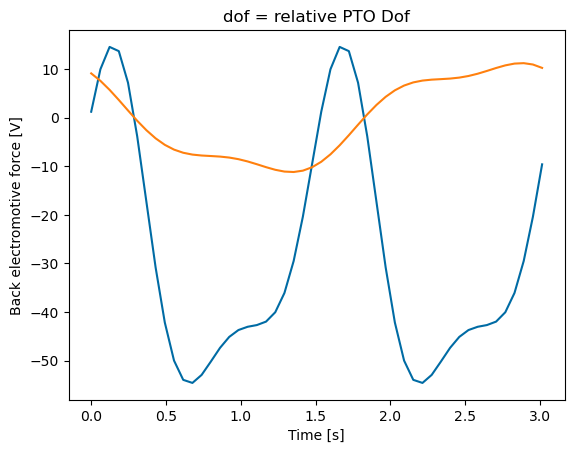

In [19]:
pen_tdom[0]['epower'].plot()

pen_tdom[0]['back_emf'].plot()